# Оптимизация работы модели трансформера с короткими текстами

**Проблема.** Для подачи данных в модель BERT необходимо привести все тексты к одной длине. Однако, если в корпусе есть короткие и длинные тексты, это приводит к тому, что после токенизации большая часть коротких текстов будет состоять из специального токена – PAD, который используется для приведения корпуса текстов к одной длине.

**Классический подход**

GPU работает гораздо эффективнее, когда подается несколько обучающих образцов (батч или партия) для параллельной работы модели. Однако для того, чтобы GPU работал с партией, все входные данные должны быть одинаковой длины. Для этого принято приводить все входные последовательности к одной фиксированной длине. Если максимальная длина текста в корпусе более 512 токенов, то все тексты приводятся к данной длине, если же менее 512 токенов, то тексты приводятся к длине равной максимальной длине в корпусе


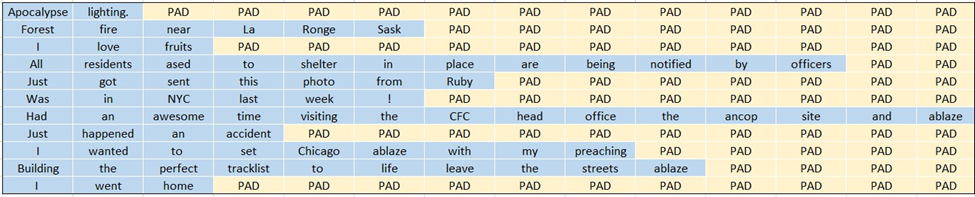

**Предполагаемый подход**


Основная идея подхода состоит в том, что хотя все тексты в одном батче должны иметь одинаковую длину, для модели BERT не имеет значения какая это длина, это приводит к тому, что батчи могут быть разной длины


Если провести ещё одну модификацию и отсортировать набор данных по длине перед созданием партий, то это позволит повысить эффективность подхода.

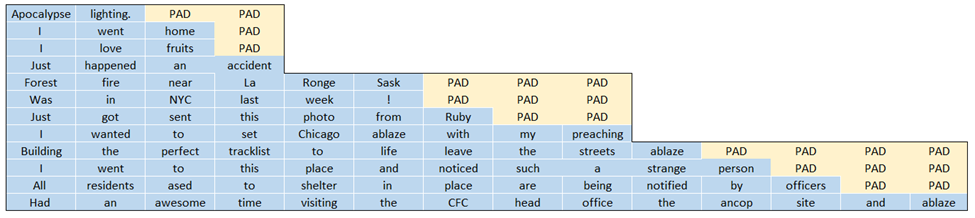

 Уменьшение длины входной последовательности, за счет использования данного подхода, должно привести к значительному сокращению времени создания векторного представления текста.

## Загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import json

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader

## Загрузка данных

В качестве набора данных используются данные медицинских статей, полученные с платформы Arxiv.org


[Ссылка](https://www.kaggle.com/datasets/ekaterinamayatskaya/medical-articles)

In [ ]:
df = pd.read_pickle('df_new_10.pkl')

In [ ]:
df

,Название статьи,Абстракт,Ссылка,Метка,length
0,RECOVER: sequential model optimization platfor...,"For large libraries of small molecules, exhaus...",https://arxiv.org/abs/2202.04202,Cancer,236.0
1,Unsupervised heart abnormality detection based...,Heart Sound (also known as phonocardiogram (PC...,https://arxiv.org/abs/2101.05443,cardiovascular,156.0
2,"Modularity ""for free"" in genome architecture?",Background: Recent models of genome-proteome e...,https://arxiv.org/abs/q-bio/0312032,genetics,203.0
3,Representing and extracting knowledge from sin...,Single-cell analysis is currently one of the m...,https://arxiv.org/abs/2304.13084,genetics,162.0
4,Predicted disease compositions of human glioma...,Background and Purpose: Biopsy is the main det...,https://arxiv.org/abs/1908.02334,Cancer,250.0
...,...,...,...,...,...
18967,Unveiling the mystery of visual information pr...,It is generally accepted that human vision is ...,https://arxiv.org/abs/0807.0337,brain disease,238.0
18968,On the Impact of Mutation-Selection Balance on...,The interplay between mutation and selection p...,https://arxiv.org/abs/1012.3098,genetics,195.0
18969,Improving Prognostic Performance in Resectable...,As an analytic pipeline for quantitative imagi...,https://arxiv.org/abs/1907.04822,Cancer,214.0
18970,Analysis of DNA sequence variation within mari...,We apply recently developed inference methods ...,https://arxiv.org/abs/1209.0813,DNA/RNA,121.0


In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
        Эта функция пытается выбрать интеллектуальный интервал обновления выбора батча
        на основе величины общего количества итераций.

        Параметры:
            `total_iters` - количество итераций в цикле for.
            `num_desired_updates` - сколько раз мы хотим видеть обновление в течение цикла for.
    '''
    # Разделить общее количество итераций на желаемое количество обновлений.
    # Получится не очень красиво число
    exact_interval = total_iters / num_desired_updates


    # Чтобы определить величину, до которой нужно округлить, найдите величину итогового значения,
    # а затем уменьшите ее на одну величину.

    # Получите порядок величины от общего числа.
    order_of_mag = len(str(total_iters)) - 1

    # Интервал обновления должен быть округлен на порядок меньше.
    round_mag = order_of_mag - 1

    # Округлить в меньшую сторону и преобразовать в int.
    update_interval = int(round(exact_interval, -round_mag))

    # Не допускать, чтобы интервал был равен нулю!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Принимает время в секундах и возвращает строку чч:мм:сс
    '''
    # Округлить до ближайшей секунды.
    elapsed_rounded = int(round((elapsed)))

    # Формат вывода hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
df['Метка'] = label_encoder.fit_transform(df['Метка'])

In [ ]:
labels = df['Метка'].to_numpy()

In [ ]:
corpus = df['Абстракт'].to_numpy()

## Токенизация

Используем иодель трансформера предобученную на медицинских данных

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12', do_lower_case=True)

Обрезаем текст до длины 510 токенов

In [ ]:
max_len = 510

In [ ]:
full_input_ids = []
# labels = []


print('Tokenizing {:,} training samples...'.format(len(corpus)))

update_interval = good_update_interval(total_iters=len(corpus), num_desired_updates=10)

for text in corpus:

    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Токенизация
    input_ids = tokenizer.encode(text=text,              # Текст для кодировки
                                    add_special_tokens=True, # Добавить специальные токены
                                    max_length=max_len,      # Максимальная длина обрезания текста
                                    truncation=True,         # Маркер необходимо ли усечение
                                    padding=False)           # Маркер необходим ли паддинг

    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 18,972 training samples...
  Tokenized 0 samples.
  Tokenized 2,000 samples.
  Tokenized 4,000 samples.
  Tokenized 6,000 samples.
  Tokenized 8,000 samples.
  Tokenized 10,000 samples.
  Tokenized 12,000 samples.
  Tokenized 14,000 samples.
  Tokenized 16,000 samples.
  Tokenized 18,000 samples.
DONE.
    18,972 samples


Прежде чем сортировать образцы по длине, давайте посмотрим на длину образцов в исходном, несортированном порядке.

Приведенный ниже график просто подтверждает, что длины образцов действительно существенно различаются, и что они не отсортированы.

In [ ]:
# Получим длины текстов
unsorted_lengths = [len(x) for x in full_input_ids]

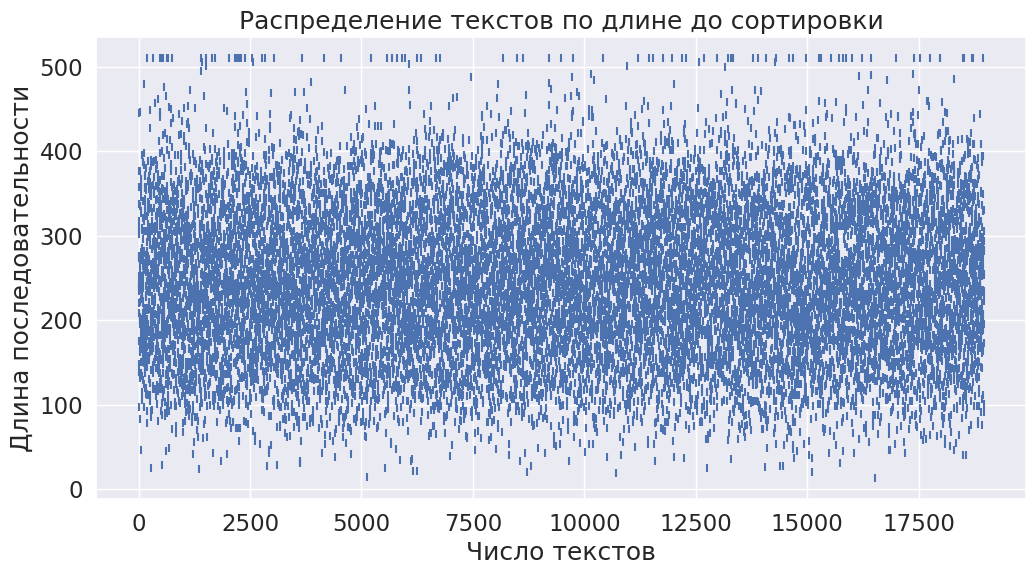

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Число текстов')
plt.ylabel('Длина последовательности')
plt.title('Распределение текстов по длине до сортировки')

plt.show()

Длина текстов в основном до 100 токенов
Поэтому когда мы будем заполнять их pad, большая часть предложений будет состоять из них

Теперь отсортируем примеры по длине, чтобы создать партии с одинаковой длиной.

In [ ]:
train_samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

`train_samples` -это список кортежей (input_ids, label):

In [ ]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 13
Longest sample: 510


Снова построим тот же график, теперь уже с сортировкой образцов по длине.

In [ ]:
sorted_lengths = [len(s[0]) for s in train_samples]

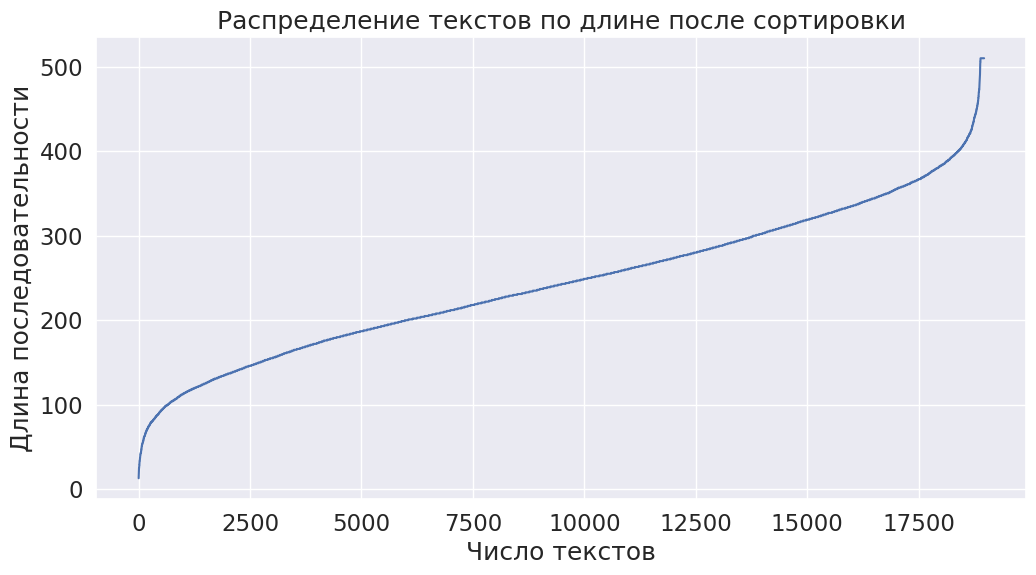

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Число текстов')
plt.ylabel('Длина последовательности')
plt.title('Распределение текстов по длине после сортировки')

plt.show()

Разделим на батчи

Вместо того чтобы распределять партии по порядку, мы все же добавим некоторую долю случайности в наш выбор.

- Выбираем случайную начальную точку в (отсортированном!) списке образцов.
- Возьмем непрерывную партию образцов, начиная с этой точки.
- Удаляем эти образцы из списка и повторяем до тех пор, пока не будут взяты все образцы.

In [ ]:
batch_size =3

In [ ]:
import random

# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Проходимся по всем сэмплам
while len(samples) > 0:

    # Вывод прогресса
    if ((len(batch_ordered_sentences) % update_interval) == 0 \
        and not len(batch_ordered_sentences) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` - это фактический размер партии. Он будет `batch_size` до тех пор, пока
    # мы не дойдем до последней партии, которая может быть меньше.
    to_take = min(batch_size, len(samples))

    # Выберите случайный индекс в списке оставшихся батчей, чтобы проводить
    # отбор случайно
    select = random.randint(0, len(samples) - to_take)

    # Выберите непрерыную партию батчей начиная с `select`.
    #print("Selecting batch from {:} to {:}".format(select, select+to_take))
    batch = samples[select:(select + to_take)]

    #print("Batch length:", len(batch))

    # Каждый образец представляет собой кортеж - разделите их на части, чтобы создать отдельный список
    # последовательностей текста и список меток для этого пакета.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Удаляем из списка уже использованные батчи
    del samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 3
  Selected 0 batches.
  Selected 500 batches.
  Selected 1,000 batches.
  Selected 1,500 batches.
  Selected 2,000 batches.
  Selected 2,500 batches.
  Selected 3,000 batches.
  Selected 3,500 batches.
  Selected 4,000 batches.
  Selected 4,500 batches.
  Selected 5,000 batches.
  Selected 5,500 batches.
  Selected 6,000 batches.

  DONE - 6,324 batches.


## Добавленяем PAD
Мы создали наши партии, но многие из них будут содержать последовательности разной длины. Для того чтобы использовать параллельную обработку пакетов на GPU, все последовательности в пакете должны быть одинаковой длины.

Это означает, что нам необходимо привести их к одинаковой длине, заполняя текст PAD до нужно длины


Здесь же мы создадим маски внимания и переведем все в тензоры PyTorch для подготовки к этапу тонкой настройки.

In [ ]:
import torch

py_inputs = []
py_attn_masks = []
py_labels = []
lab=[]
# Для каждого батча..
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # Новая версия батча, на этот раз с дополненными последовательностями до максимальной длины, а также
    # с маской внимания.
    batch_padded_inputs = []
    batch_attn_masks = []

    # Сначала найдите самый длинный образец в батче.
    # Обратите внимание, что в настоящее время последовательности содержат специальные токены!
    max_size = max([len(sen) for sen in batch_inputs])

    # Для каждого текста в батче
    for sen in batch_inputs:

        # Сколько специальных токенов необходимо добавить
        num_pads = max_size - len(sen)

        # Добавьте токены заполнения `num_pads` в конец последовательности.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Определить маску внимания, это - `1` для реального токена
        # и - `0` для специального токена
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Добавить результат в список
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # В каждом батче был проведен паддинг, поэтому нам нужно сохранить этот обновленный пакет.
    # Нам также нужно, чтобы входные данные были тензорами PyTorch.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))
    lab.append(batch_labels)

In [ ]:
# Получим список отсортированных длин
padded_lengths = []


for batch in py_inputs:

    for s in batch:
        padded_lengths.append(len(s))

# Суммарное число токенов после токенизации рассмотренным способом
smart_token_count = np.sum(padded_lengths)

# Суммарное число токенов после токенизации классическим способом, при приведении текстов к максимальной длине в корпусе
fixed_token_count = len(corpus) * max_len

# Расчет уменьшения числа токенов
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
   Fixed Padding: 9,675,720
  Smart Batching: 4,650,951  (51.9% less)


Загружаем модель трансформера

In [ ]:
from transformers import  BertModel, RobertaModel

model = BertModel.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12', output_hidden_states = True)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print('  GPU:', torch.cuda.get_device_name(0))


  GPU: Tesla T4


## Получение векторных представлений текста

In [ ]:
def make_smart_batches(text_samples, labels, batch_size):
    '''
    Эта функция объединяет все необходимые шаги для приготовления батчей.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Токенизация & Усечение
    # =========================

    full_input_ids = []

    # Токенизация всех сэмплов
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Выбрать интервал обновления батчей
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # Для каждого тренировочного сэмпла проводим токенизацию
    for text in text_samples:

        # Отчет о прогрессе
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Токенизация
        input_ids = tokenizer.encode(text=text,              # Текст для кодировки
                                    add_special_tokens=True, # Добавить специальные токены
                                    max_length=max_len,      # Максимальная длина обрезания текста
                                    truncation=True,         # Маркер необходимо ли усечение
                                    padding=False)           # Маркер необходим ли паддинг

        # Добавляем результат в список
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Выбор батчей
    # =========================

    # Отсортируем два списка вместе по длине входной последовательности.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # Список батчей, которые мы создадим.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Выберите интервал обновления батчей
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Проходимся по всем сэмплам
    while len(samples) > 0:

        # Вывод прогресса
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` - это фактический размер партии. Он будет `batch_size` до тех пор, пока
        # мы не дойдем до последней партии, которая может быть меньше.
        to_take = min(batch_size, len(samples))

        # Выберите случайный индекс в списке оставшихся батчей, чтобы проводить
        # отбор случайно
        select = random.randint(0, len(samples) - to_take)

        # Выберите непрерыную партию батчей начиная с `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Каждый образец представляет собой кортеж - разделите их на части, чтобы создать отдельный список
        # последовательностей текста и список меток для этого пакета.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Удаляем из списка уже использованные батчи
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Добавка паддинга
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []
    lab=[]
    # Для каждого батча..
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # Новая версия батча, на этот раз с дополненными последовательностями до максимальной длины, а также
        # с маской внимания.
        batch_padded_inputs = []
        batch_attn_masks = []

        # Сначала найдите самый длинный образец в батче.
        # Обратите внимание, что в настоящее время последовательности содержат специальные токены!
        max_size = max([len(sen) for sen in batch_inputs])

        # Для каждого текста в батче
        for sen in batch_inputs:

            # Сколько специальных токенов необходимо добавить
            num_pads = max_size - len(sen)

            # Добавьте токены заполнения `num_pads` в конец последовательности.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Определить маску внимания, это - `1` для реального токена
            # и - `0` для специального токена
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Добавить результат в список
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # В каждом батче был проведен паддинг, поэтому нам нужно сохранить этот обновленный пакет.
        # Нам также нужно, чтобы входные данные были тензорами PyTorch.
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
        lab.append(batch_labels)


    print('  DONE.')

    # Возвращаем данные
    return (py_inputs, py_attn_masks, py_labels, lab)

Функция взятия среднего для каждого вектора слова

Слой last_hidden_state выдает вектор размерности 3, где для каждого слова формируется вектор размерности 768, работа с такими данными требует больших вычислительных ресурсов. Для решения данной проблемы необходимо взять среднее значение для векторов слов. На выходе получаем, что каждое слово характеризуется одним числом, каждый текст - это вектор размерности 768

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output['last_hidden_state']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
batch_size=8

In [ ]:
(py_inputs, py_attn_masks, py_labels, labe) = make_smart_batches(corpus, labels, batch_size)

Creating Smart Batches from 18,972 examples with batch size 8...

Tokenizing 18,972 samples...
  Tokenized 0 samples.
  Tokenized 2,000 samples.
  Tokenized 4,000 samples.
  Tokenized 6,000 samples.
  Tokenized 8,000 samples.
  Tokenized 10,000 samples.
  Tokenized 12,000 samples.
  Tokenized 14,000 samples.
  Tokenized 16,000 samples.
  Tokenized 18,000 samples.
DONE.
    18,972 samples

    18,972 samples after sorting

Creating batches of size 8...
  Selected 2,000 batches.

  DONE - Selected 2,372 batches.

Padding out sequences within each batch...
  DONE.


In [ ]:

model.eval()

lab=torch.Tensor().to(device)
embeddings = torch.Tensor().to(device)

# Выбор интервала обновления
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=16)

# Фиксирование времени начала
t0 = time.time()

# Переведите модель в режим оценки
model.eval()
latency = []
# Проходимся по каждому батчу
for step in range(0, len(py_inputs)):

    # Вывод прогресса для каждый 100 батчей
    if step % update_interval == 0 and not step == 0:

        elapsed = format_time(time.time() - t0)

        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)


        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Передача данных на GPU
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)


    with torch.no_grad():
        start = time.time()
        result = model(b_input_ids)
        latency.append(time.time() - start)
        embeddings = torch.cat([embeddings, mean_pooling(result, b_input_mask)])
embeddings = embeddings.cpu().numpy()
print("PyTorch {} Inference time = {} ms".format(device.type, format(sum(latency) * 1000 / len(latency), '.2f')))

  Batch     100  of    2,372.    Elapsed: 0:00:12.  Remaining: 0:04:25
  Batch     200  of    2,372.    Elapsed: 0:00:24.  Remaining: 0:04:18
  Batch     300  of    2,372.    Elapsed: 0:00:37.  Remaining: 0:04:15
  Batch     400  of    2,372.    Elapsed: 0:00:50.  Remaining: 0:04:04
  Batch     500  of    2,372.    Elapsed: 0:01:02.  Remaining: 0:03:51
  Batch     600  of    2,372.    Elapsed: 0:01:14.  Remaining: 0:03:40
  Batch     700  of    2,372.    Elapsed: 0:01:26.  Remaining: 0:03:26
  Batch     800  of    2,372.    Elapsed: 0:01:38.  Remaining: 0:03:13
  Batch     900  of    2,372.    Elapsed: 0:01:50.  Remaining: 0:03:00
  Batch   1,000  of    2,372.    Elapsed: 0:02:02.  Remaining: 0:02:47
  Batch   1,100  of    2,372.    Elapsed: 0:02:15.  Remaining: 0:02:36
  Batch   1,200  of    2,372.    Elapsed: 0:02:27.  Remaining: 0:02:23
  Batch   1,300  of    2,372.    Elapsed: 0:02:39.  Remaining: 0:02:11
  Batch   1,400  of    2,372.    Elapsed: 0:02:51.  Remaining: 0:01:59
  Batc

In [ ]:
np.save('padding_bert_base', embeddings)

In [ ]:
embeddings = np.load('Новый датасет/padding_bert_base.npy')

In [ ]:
labe_list = [item for sublist in labe for item in sublist]

## Классификация

In [ ]:
import pandas as pd
import numpy as np
# np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
# from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard

In [ ]:
emb=np.array(embeddings)

In [ ]:
emb = np.expand_dims(emb, 1)

In [ ]:
emb.shape

(18972, 1, 768)

In [ ]:
labe_list = np.asarray(labe_list)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(emb, labe_list,test_size=0.2)

In [ ]:
from keras import layers
text_input = Input(shape=(1, 768), dtype='float64', name='text')

encoded_text = layers.LSTM(768,)(text_input)
drop= layers.Dropout(0.)(encoded_text)
out_dense = layers.Dense(256, activation='relu')(drop)

out = layers.Dense(10, activation='softmax')(out_dense)
model = Model(text_input, out)
opt = keras.optimizers.Adam(learning_rate= 0.001,)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1, 768)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 768)               4721664   
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               196864    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 4921098 (18.77 MB)
Trainable params: 4921098 (18.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
history = model.fit(x_train, y_train, epochs=80, batch_size=1000, validation_split=0.3, callbacks=[call_reduce])

Epoch 1/80
11/11 [==============================] - 3s 70ms/step - loss: 1.8913 - acc: 0.3528 - val_loss: 1.5688 - val_acc: 0.4409 - lr: 0.0010
Epoch 2/80
11/11 [==============================] - 0s 22ms/step - loss: 1.3042 - acc: 0.5449 - val_loss: 1.0290 - val_acc: 0.6440 - lr: 0.0010
Epoch 3/80
11/11 [==============================] - 0s 19ms/step - loss: 0.8796 - acc: 0.7112 - val_loss: 0.7951 - val_acc: 0.7383 - lr: 0.0010
Epoch 4/80
11/11 [==============================] - 0s 17ms/step - loss: 0.7213 - acc: 0.7612 - val_loss: 0.7006 - val_acc: 0.7626 - lr: 0.0010
Epoch 5/80
11/11 [==============================] - 0s 17ms/step - loss: 0.6400 - acc: 0.7845 - val_loss: 0.6612 - val_acc: 0.7789 - lr: 0.0010
Epoch 6/80
11/11 [==============================] - 0s 20ms/step - loss: 0.5948 - acc: 0.7985 - val_loss: 0.6187 - val_acc: 0.7846 - lr: 0.0010
Epoch 7/80
11/11 [==============================] - 0s 17ms/step - loss: 0.5614 - acc: 0.8069 - val_loss: 0.5950 - val_acc: 0.7989 - lr:

In [ ]:
y_pred = model.predict(x_test, batch_size=500, verbose=1)
y_pred_b = np.argmax(y_pred, axis=1)

8/8 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import classification_report

In [ ]:

report = classification_report(
     y_test,
    y_pred_b,

)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       683
           1       0.82      0.79      0.80       316
           2       0.78      0.67      0.72       162
           3       0.85      0.91      0.88       298
           4       0.78      0.71      0.74       167
           5       0.93      0.89      0.91       152
           6       0.79      0.85      0.82      1222
           7       0.84      0.83      0.83       111
           8       0.80      0.58      0.67       389
           9       0.70      0.85      0.77       295

    accuracy                           0.80      3795
   macro avg       0.81      0.79      0.79      3795
weighted avg       0.80      0.80      0.79      3795

